# JリーグにおけるxGに関する探索的データ解析

xG（ゴール期待値）を計算することによって、１試合において実際に決めたゴール数ではなく、入るべきだったゴールが分かります。
この指標を用いることでチャンスメイクの数の評価やチャンスをどのぐらいものにできたのかも定量的に評価できます。

xGは様々なモデルがありますが、それらを定量的に評価しているものは少ないです。また、日本でどのモデルが最適化という研究も一切されていません。
そこで私達はJリーグのデータを活用して、どのようなデータを使えば最適なxGモデルができるのかについて研究しました。

In [1]:
# 下準備に今回使うライブラリと使うデータを最初にすべて読み込む

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl
import numpy as np
import chainer

df = pd.read_csv('shootdata.csv',encoding='SHIFT_JIS')

dfにはシュート時の詳細なデータが含まれています。
どこで、どの選手がどこにシュートを打ったのか。またそれが入ったのか入らなかったのか。
これらのことが分かります。

In [2]:
df.describe()

,date,shootnum,playnum,yearnum,Jleague,seasonid,round,homeaway,teamid,gameid,...,boaly,cellid,pk,official,officialteamid,officialplayerid,officialpartid,a,b,c
count,1.218000e+03,1218.000000,1.218000e+03,1218.0,1218.0,1218.0,1218.0,1218.000000,1218.000000,1218.000000,...,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000,1.218000e+03,1218.000000,1218.000000,1218.0,1218.0
mean,2.016102e+09,15.115764,1.825251e+08,30028.0,2.0,3.0,1.0,1.487685,151.368637,1.592775,...,0.373153,157.082923,0.006568,0.789819,117.452381,7.350515e+05,1.434319,0.302956,0.0,24.0
std,5.574658e+03,9.205616,1.038465e+08,0.0,0.0,0.0,0.0,0.500054,50.116196,0.491519,...,27.212298,109.460576,0.080811,0.407604,74.685172,5.516319e+05,0.957282,0.459725,0.0,0.0
min,2.016093e+09,1.000000,5.367000e+03,30028.0,2.0,3.0,1.0,1.000000,86.000000,1.000000,...,-86.500000,5.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,24.0
25%,2.016100e+09,7.000000,8.391531e+07,30028.0,2.0,3.0,1.0,1.000000,124.000000,1.000000,...,-18.000000,39.250000,0.000000,1.000000,86.000000,4.430000e+03,1.000000,0.000000,0.0,24.0
50%,2.016102e+09,14.000000,2.078744e+08,30028.0,2.0,3.0,1.0,1.000000,131.000000,2.000000,...,0.000000,217.000000,0.000000,1.000000,128.000000,8.002100e+05,2.000000,0.000000,0.0,24.0
75%,2.016103e+09,22.000000,2.753538e+08,30028.0,2.0,3.0,1.0,2.000000,150.000000,2.000000,...,19.500000,263.000000,0.000000,1.000000,136.000000,1.201326e+06,2.000000,1.000000,0.0,24.0
max,2.016110e+09,43.000000,3.522037e+08,30028.0,2.0,3.0,1.0,2.000000,270.000000,2.000000,...,69.500000,295.000000,1.000000,1.000000,270.000000,1.604111e+06,3.000000,1.000000,0.0,24.0


In [4]:
print(df.columns.values)

['date' 'shootnum' 'playnum' 'yearnum' 'Jleague' 'seasonid' 'round'
 'homeaway' 'teamid' 'gameid' 'time' 'shootplayerid' 'shootplayer'
 'goalposition' 'goalx' 'goaly' 'shootpart' 'shoottype' 'gkx' 'gky'
 'success' 'distance' 'vgoal' 'gkplayerid' 'gkplayer' 'assist' 'owngoal'
 'action' 'boalx' 'boaly' 'cellcoad' 'cellid' 'pk' 'official'
 'officialteamid' 'officialplayerid' 'officialpartid' 'a' 'b' 'c']


## 最も基本的なゴール期待値

ゴール期待値の最も簡単なモデルはシュートを打ったときの

・ゴールからの距離

・ゴールとの角度

の２つのデータを取り入れたものなります。

ここでは、同じことを意味するシュート時のボールのx,y座標を用いてゴール期待値を計算しようと思います。

### 座標と成功・失敗の可視化

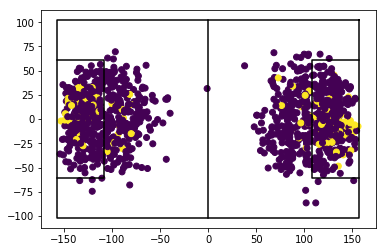

In [3]:
# ｘ，ｙ座標データとシュートの成功（１）、失敗（０）データをdfから取り出します。
x = df['boalx']
y = df['boaly']
label = df['success']
        
# ピッチを描く関数を定義します。
def plot_pitch():
    areax = [157.5,157.5,-157.5,-157.5,157.5]
    areay = [102,-102,-102,102,102]
    plt.plot(areax,areay,color='black')
    centerx = [0,0]
    centery = [-102,102]
    plt.plot(centerx,centery,color='black')
    rpax = [157.5,108,108,157.5]
    rpay = [-60.48,-60.48,60.48,60.48]
    plt.plot(rpax,rpay,color='black')
    lpax = [-157.5,-108,-108,-157.5]
    lpay = [-60.48,-60.48,60.48,60.48]
    plt.plot(lpax,lpay,color='black')

    
#　シュートを打った位置とゴールしたかを可視化します。
plot_pitch()
plt.scatter(x,y,c=label)
plt.show()

しかし、ここで問題発生です。
攻撃方向が２つあるのでどちらかの方向に合わせなくてはなりません。
正しい方法ではありませんが、今は応急処置として左側の店を右側に全部反転します。

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


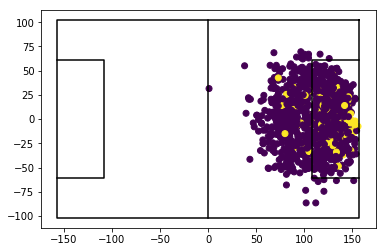

In [6]:
#　真ん中は０なので、負の値に-1をかけます
for index,element in enumerate(x):
    if element < 0:
        x[index] *= -1

plot_pitch()
plt.scatter(x,y,c=label)
plt.show()

## 単変量解析分析
### 線形モデルの作成

係数: 
 [[0.000191]]
平均二乗誤差: 0.08
Variance score: -0.00


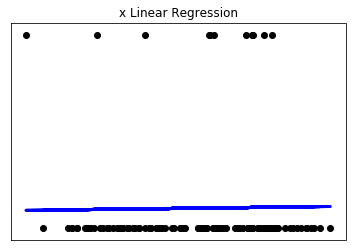

係数: 
 [[0.00032494]]
平均二乗誤差: 0.08
Variance score: -0.00


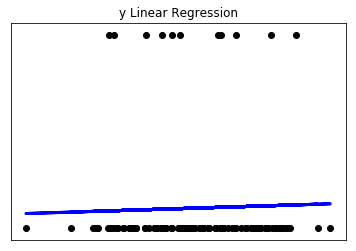

In [7]:
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score

# sklearn用にデータの形を整理します。
X = x.values.reshape(-1,1)
Y = y.values.reshape(-1,1)
L = label.values.reshape(-1,1)
# トレーニング用とテスト用にデータを分割します。
# 7:3に分割します。
X_train, X_test = model_selection.train_test_split(X, test_size=0.1)
Y_train, Y_test = model_selection.train_test_split(Y, test_size=0.1)
L_train, L_test = model_selection.train_test_split(L, test_size=0.1)

#  線形モデルを作成します。
regr = linear_model.LinearRegression()
# 線形モデルを学習させます。
regr.fit(X_train, L_train)

# 学習済みの線形モデルにテストデータを入れて、ゴールしたかを予想します。
L_pred = regr.predict(X_test)

# 係数表示
print('係数: \n', regr.coef_)
# 平均二乗誤差表示
print("平均二乗誤差: %.2f" % mean_squared_error(L_test, L_pred))

# Explained variance score: 1 ならば完璧な予測
print('Variance score: %.2f' % r2_score(L_test, L_pred))

# 結果をプロット
plt.scatter(X_test, L_test,  color='black')
plt.plot(X_test, L_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.title('x Linear Regression')
plt.show()

#  線形モデルを作成します。
regr = linear_model.LinearRegression()
Y = y.values.reshape(-1,1)
regr.fit(Y_train, L_train)
L_pred = regr.predict(Y_test)
print('係数: \n', regr.coef_)
print("平均二乗誤差: %.2f" % mean_squared_error(L_test, L_pred))
print('Variance score: %.2f' % r2_score(L_test, L_pred))
plt.scatter(Y_test, L_test,  color='black')
plt.plot(Y_test, L_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.title('y Linear Regression')
plt.show()


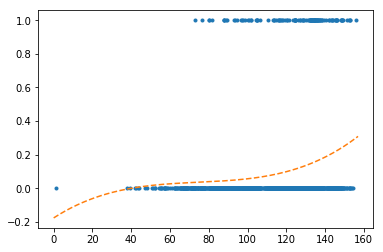

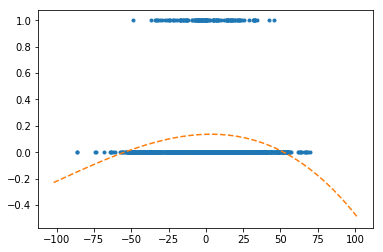

In [66]:
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score

# sklearn用にデータの形を整理します。
X = x.values.reshape(-1,1)
Y = y.values.reshape(-1,1)
L = label.values.reshape(-1,1)
# トレーニング用とテスト用にデータを分割します。
# 7:3に分割します。
X_train, X_test = model_selection.train_test_split(X, test_size=0.1)
Y_train, Y_test = model_selection.train_test_split(Y, test_size=0.1)
L_train, L_test = model_selection.train_test_split(L, test_size=0.1)

p = np.polyfit(x, label, 3)
p = np.poly1d(p)

xp = np.linspace(0, 157, 157)
_ = plt.plot(x, label, '.', xp, p(xp), '--')
plt.show()


p = np.polyfit(y, label, 3)
p = np.poly1d(p)

xp = np.linspace(-102, 102, 204)
_ = plt.plot(y, label, '.', xp, p(xp), '--')
plt.show()

### ロジスティック回帰

In [54]:
p(5)

TypeError: 'numpy.ndarray' object is not callable

係数: 
 [[-0.00190031]]
平均二乗誤差: 0.09
Variance score: -0.10


/home/atom/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/atom/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


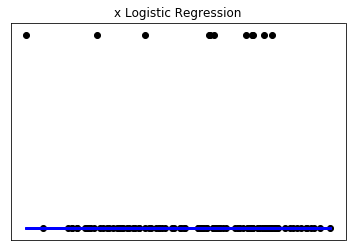

/home/atom/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/atom/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


係数: 
 [[0.0034752]]
平均二乗誤差: 0.09
Variance score: -0.10


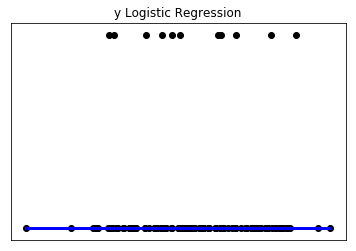

In [8]:
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, L_train)
L_pred = log_reg.predict(X_test)
print('係数: \n', log_reg.coef_)
print("平均二乗誤差: %.2f" % mean_squared_error(L_test, L_pred))
print('Variance score: %.2f' % r2_score(L_test, L_pred))
plt.scatter(X_test, L_test,  color='black')
plt.plot(X_test, L_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.title('x Logistic Regression')
plt.show()

log_reg = linear_model.LogisticRegression()
log_reg.fit(Y_train, L_train)
L_pred = log_reg.predict(Y_test)
print('係数: \n', log_reg.coef_)
print("平均二乗誤差: %.2f" % mean_squared_error(L_test, L_pred))
print('Variance score: %.2f' % r2_score(L_test, L_pred))
plt.scatter(Y_test, L_test,  color='black')
plt.plot(Y_test, L_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.title('y Logistic Regression')
plt.show()

## ２変量回帰分析
### 線形回帰&ロジスティック回帰

In [27]:
X = X+157.5
Y = Y+102
data = np.hstack([X,Y])

#  線形モデル
regr = linear_model.LinearRegression()
X_train, X_test = model_selection.train_test_split(data, test_size=0.3)
L_train, L_test = model_selection.train_test_split(L, test_size=0.3)
regr.fit(X_train, L_train)
L_pred = regr.predict(X_test)
print('係数: \n', regr.coef_)
print("平均二乗誤差: %.2f" % mean_squared_error(L_test, L_pred))
print('Variance score: %.2f' % r2_score(L_test, L_pred))

#  ロジスティックモデル
log_reg = linear_model.LogisticRegression()
X_train, X_test = model_selection.train_test_split(data, test_size=0.3)
L_train, L_test = model_selection.train_test_split(L, test_size=0.3)
log_reg.fit(X_train, L_train)
L_pred = log_reg.predict(X_test)
print('係数: \n', regr.coef_)
print("平均二乗誤差: %.2f" % mean_squared_error(L_test, L_pred))
print('Variance score: %.2f' % r2_score(L_test, L_pred))

係数: 
 [[ 5.68184202e-04 -3.76795700e-05]]
平均二乗誤差: 0.10
Variance score: -0.01
係数: 
 [[ 5.68184202e-04 -3.76795700e-05]]
平均二乗誤差: 0.12
Variance score: -0.14


/home/atom/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/atom/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 可視化

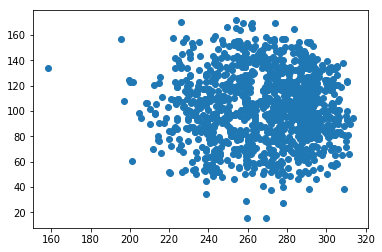

In [33]:
plt.scatter(X,Y)
plt.show()

[[-0.51722936 -0.51716041 -0.51709145 ... -0.49578559 -0.49571664
  -0.49564769]
 [-0.51494803 -0.51487908 -0.51481012 ... -0.49350426 -0.49343531
  -0.49336636]
 [-0.5126667  -0.51259775 -0.51252879 ... -0.49122293 -0.49115398
  -0.49108503]
 ...
 [-0.05868206 -0.05861311 -0.05854416 ... -0.0372383  -0.03716935
  -0.03710039]
 [-0.05640073 -0.05633178 -0.05626283 ... -0.03495697 -0.03488802
  -0.03481906]
 [-0.0541194  -0.05405045 -0.0539815  ... -0.03267564 -0.03260669
  -0.03253774]]


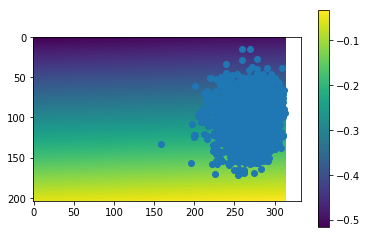

In [39]:
#  線形モデル
# X_train, X_test = model_selection.train_test_split(data, test_size=0)
# L_train, L_test = model_selection.train_test_split(L, test_size=0)
regr.fit(data, L)

x_range = np.linspace(0,157*2,157*2)
y_range = np.linspace(0,102*2,102*2)

pred_map = np.zeros([len(y_range),len(x_range)])
for x_index,_x in enumerate(x_range):
    for y_index,_y in enumerate(y_range):
        val = regr.predict([[_y,_x]])
        pred_map[y_index][x_index] = val
        
#         print('x: {0}, y: {1} -> {2}%'.format(_x,_y,  val))
    
print(pred_map)
plt.imshow(pred_map)
plt.colorbar()
plt.scatter(X,Y)
plt.show()

/home/atom/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/atom/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


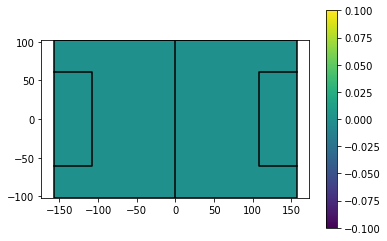

In [107]:
#  ロジスティックモデル
X_train, X_test = model_selection.train_test_split(data, test_size=0)
L_train, L_test = model_selection.train_test_split(L, test_size=0)
log_reg.fit(X_train, L_train)

x_range = np.linspace(-157,157,157*2)
y_range = np.linspace(-102,102,102*2)

pred_map = np.zeros([len(x_range),len(y_range)])
for x_index,_x in enumerate(x_range):
    for y_index,_y in enumerate(y_range):
        pred_map[x_index][y_index] = log_reg.predict([[_x,_y]])
    
plt.imshow(pred_map, extent=[-157, 157,-102, 102])
plot_pitch()
plt.colorbar()
plt.show()

## Deep Learningの活用

In [42]:
data = np.hstack([X,Y])
data, L

(array([[238. ,  52.5],
        [289.5,  99. ],
        [271.5, 131.5],
        ...,
        [278.5, 115. ],
        [299.5, 116. ],
        [294. ,  92.5]]), array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]]))

In [46]:
import numpy as np
import chainer
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

train = datasets.TupleDataset(data.astype('float32'),label)
batchsize = 1

train_iter = iterators.SerialIterator(train, batchsize)
    
class MLP(Chain):

    def __init__(self, n_mid_units=3, n_out=1):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(2, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, 1)

    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(h1))
        return F.sigmoid(self.l3(h2))

gpu_id = -1  # Set to -1 if you use CPU

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)
    
# Choose an optimizer algorithm
optimizer = optimizers.Adamax()

# Give the optimizer a reference to the model so that it
# can locate the model's parameters.
optimizer.setup(model)

import numpy as np
from chainer.dataset import concat_examples
from chainer.backends.cuda import to_cpu

max_epoch = 10
while train_iter.epoch < max_epoch:

    # ---------- One iteration of the training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, gpu_id)

    # Calculate the prediction of the network
    prediction_train = model(image_train)

    # Calculate the loss with softmax_cross_entropy
    loss =  F.mean_squared_error(prediction_train, target_train.astype('float32').reshape(-1,1))

    # Calculate the gradients in the network
    model.cleargrads()
    loss.backward()

    # Update all the trainable parameters
    optimizer.update()
    # --------------------- until here ---------------------

    # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))))

AttributeError: module 'chainer.optimizers' has no attribute 'Adamax'

In [ ]:
pred_map = np.zeros([len(x_range),len(y_range)])
for x_index,_x in enumerate(x_range):
    for y_index,_y in enumerate(y_range):
        pred_map[x_index][y_index] = model(np.asarray([[_x.astype('float32'),_y.astype('float32')]])).data
    
plt.imshow(pred_map, extent=[-157, 157,-102, 102])
plot_pitch()
plt.colorbar()
plt.show()

In [210]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)


    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
    
data = np.hstack([X,Y])

net = Net()

import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (x,y) in enumerate(data, 0):
        inputs = torch.from_numpy(np.asarray([x,y])).float()
        l = torch.from_numpy(np.asarray([label[i]])).float()
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, l)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / 2000))
    print(inputs, l, outputs.data,loss.data)
    running_loss = 0.0

mn = nn.Threshold(0, 0)
mx = nn.Threshold(-1, -1)
for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (x,y) in enumerate(data, 0):
        inputs = torch.from_numpy(np.asarray([x,y])).float()
        l = torch.from_numpy(np.asarray([label[i]])).float()
        optimizer.zero_grad()
        outputs = mn(outputs)
        outputs = mx(-outputs)
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, l)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
#     print('[%d, %5d] loss: %.3f' %
#           (epoch + 1, i + 1, running_loss / 2000))
#     print(inputs, l, outputs.data,loss.data)
    running_loss = 0.0

print('Finished Training')

[1,  1218] loss: 0.061
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0492]) tensor(0.0024)
[2,  1218] loss: 0.059
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0485]) tensor(0.0024)
[3,  1218] loss: 0.057
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0526]) tensor(0.0028)
[4,  1218] loss: 0.056
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0542]) tensor(0.0029)
[5,  1218] loss: 0.055
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0528]) tensor(0.0028)
[6,  1218] loss: 0.055
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0561]) tensor(0.0032)
[7,  1218] loss: 0.054
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0605]) tensor(0.0037)
[8,  1218] loss: 0.054
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0635]) tensor(0.0040)
[9,  1218] loss: 0.054
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0694]) tensor(0.0048)
[10,  1218] loss: 0.054
tensor([136.5000,  -9.5000]) tensor([0.]) tensor([0.0676]) tensor(0.0046)
Finished Training


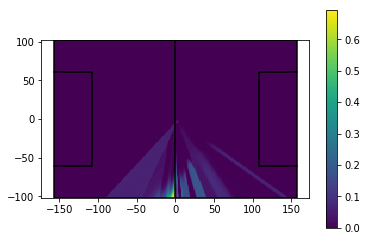

In [214]:
pred_map = np.zeros([len(x_range),len(y_range)])
for x_index,_x in enumerate(x_range):
    for y_index,_y in enumerate(y_range):
        inputs = torch.tensor([_x,_y])
        outputs = net(inputs)
        outputs = mn(outputs)

        pred_map[x_index][y_index] = outputs

plt.imshow(pred_map, extent=[-157, 157,-102, 102])
plot_pitch()
plt.colorbar()
plt.show()

In [138]:
print(inputs, l, outputs.data,loss.data)


tensor([100.,  67.])

tensor([0.])

tensor([-0.1086])

tensor(0.0118)

In [208]:
mn = nn.Threshold(0, 0)
input = torch.tensor([0.0163])
print(input)
output = mn(input)
mx = nn.Threshold(-1, -1)
output = mx(-output)
print(-output)

tensor([0.0163])
tensor([0.0163])


In [71]:

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

NameError: name 'torchvision' is not defined